Plot results based on fitting just the photometry and KCWI spectroscopy of Dragonfly 44
- compare results between different SFH models
    - Nonparametric SFH model:
        - Dirichlet SFH prior:
            - $\alpha_\mathrm{D} = 0.2$, a.k.a. the "concentrated" SFH prior (included in Webb+2022)
            - $\alpha_\mathrm{D} = 0.3$
            - $\alpha_\mathrm{D} = 0.5$
            - $\alpha_\mathrm{D} = 1$, a.k.a. the "extended" SFH prior (included in Webb+2022)
        - Continuity SFH prior:
            - prior on ratio of SFR between adjactent time bins, $\log \mathrm{SFR}_n/\mathrm{SFR}_{n+1} ~ \mathrm{Student-T}\left( \mu=0, \sigma=0.3, \nu=2 \right)$ (i.e., the default "continuity" prior in Prospector)
    - Parametric SFH model:
        - Delayed declining exponential model:
            

In [1]:
# imports 

import matplotlib.pyplot as plt

import os
# get path to Dragonfly44_SFH directory
# gross, but works
path_base = os.getcwd().split('Dragonfly44_SFH')[0]

import numpy as np
from Dragonfly44_SFH.utils import plotting
from Dragonfly44_SFH.utils.styles import *

In [2]:
result_params = {}

from Dragonfly44_SFH.fitting.output.fits_DF44_summary import *
from Dragonfly44_SFH.utils.prospect_io import read_results

path_fits = path_base+ "Dragonfly44_SFH/fitting/output/"

path_data = path_base+ "Dragonfly44_SFH/data/"
file_data = path_data+"Dragonfly44/obs_phot_specKCWI_sigma110.h5"

for sfh_key, result_file, isfh in [ 
                           ['aD02', fit_aD02_phot_specKCWI, 3],
                           ['aD03', fit_aD03_phot_specKCWI, 3],
                           ['aD05', fit_aD05_phot_specKCWI, 3],
                           ['aD1',  fit_aD1_phot_specKCWI, 3],
                           ['csfrcont', fit_csfrcont_phot_specKCWI, 3],
                           ['dexp', fit_dexp_phot_specKCWI, 4]
                          ]:
    if result_file is None: continue

    result, obs, model = read_results( path_fits+ result_file, file_data=file_data, sfh=isfh )

    result_params[sfh_key] = dict( result=result, obs=obs, model=model, 
                                   label=sfh_labels[sfh_key], sfh=isfh )

zobs = float(model.params['zred'])

In [3]:
# CHECK if each fit provided a spectrum with rough specphot calibration
# e.g. fit_aD05_phot_specKCWI includes a spectrum with normalization = 1e-8
# other fits used normalization = 1, relying entirely on spectro-photometric calibration polynomial
# for consistency, remove the normalization term!
# this is an annoying inconsistency of this project...
specnorm = 1e-8

for key in result_params.keys():
    if result_params[key]['obs']['spectrum'] is None: continue # skip if phot-only fit
        
    specnorm_in_fit = np.median( result_params[key]['obs']['spectrum'] )
    if specnorm_in_fit < 1e-3: # somewhat arbitrary threshold
        
        result_params[key]['obs']['spectrum'] /= specnorm 
        result_params[key]['obs']['unc'] /= specnorm 

        result_params[key]['result']['bestfit']['spectrum'] /= specnorm 
        result_params[key]['result']['bestfit']['speccal'] /= specnorm 
        
        if 'draws' in result_params[key]['result']: # post-processing step not always done
            result_params[key]['result']['draws']['bestfit']['spectrum'] /= specnorm 
            result_params[key]['result']['draws']['bestfit']['speccal'] /= specnorm 

In [4]:
sfh_keys = result_params.keys()

In [5]:
# setup styling

markers = ['o','s','X','v','*','^']
colors = ['orange','m','lime','c','b','r']

for i,key in enumerate( sfh_keys ):
    result_params[key]['obs_params'] = {'marker':'D', 'color':'k', 'ms':12}
    result_params[key]['posts_params'] = {'color':colors[i]}
    result_params[key]['bestfit_params'] = {'color':colors[i], 'marker':markers[i]}

## plot SED

Dirichlet($\alpha=0.2$) Bestfit $\chi^2$/N$_\mathrm{phot}$=0.90
Dirichlet($\alpha=0.2$) Bestfit $\chi^2$/N$_\mathrm{spec}$=1.02
Dirichlet($\alpha=0.5$) Bestfit $\chi^2$/N$_\mathrm{phot}$=1.01
Dirichlet($\alpha=0.5$) Bestfit $\chi^2$/N$_\mathrm{spec}$=1.03
Dirichlet($\alpha=1$) Bestfit $\chi^2$/N$_\mathrm{phot}$=0.84
Dirichlet($\alpha=1$) Bestfit $\chi^2$/N$_\mathrm{spec}$=1.03
Delayed-$\tau$ Bestfit $\chi^2$/N$_\mathrm{phot}$=0.68
Delayed-$\tau$ Bestfit $\chi^2$/N$_\mathrm{spec}$=1.04


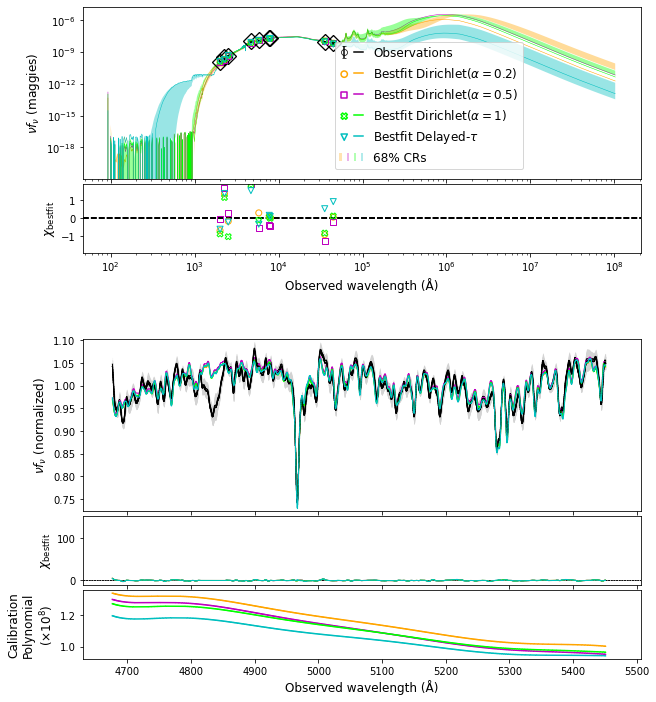

In [6]:
params_base = dict( return_fig=True, zobs=0, figsize=(10,12), show_chi2s=False )

fig = None
for key in sfh_keys:
    fig = plotting.plot_obs_and_fits( **result_params[key], fig=fig, **params_base )

if True: # add legend
    ax_legend = fig.get_axes()[0]

    handles, handles_CRs = [],[]
    labels = []
    for i,key in enumerate( sfh_keys ):
        pp = result_params[key]
        
        if i==0: # add handles for observations    
            ha = ax_legend.errorbar([-1],[-1], yerr=[1], 
                                     color=pp['obs_params']['color'], mec=pp['obs_params']['color'], 
                                     mfc='None', fmt=' ', capsize=2, ms=12, marker='o', mew=0.7)
            hb, = ax_legend.plot([],[], color=pp['obs_params']['color'])
            handles.append( (ha,hb) )
            labels.append('Observations')
        
        
            
        ha = ax_legend.scatter([],[], 
                               edgecolor=pp['bestfit_params']['color'], facecolor='None', 
                               marker=pp['bestfit_params']['marker'], zorder=2, s=160, lw=1.5, )
        hb, = ax_legend.plot([],[], color=pp['bestfit_params']['color'])
        handles.append( (ha,hb) )
        if 'label' in pp.keys(): l = pp['label']
        elif 'label' in pp['bestfit_params'].keys(): pp['bestfit_params']['label']
        else: l = i+1
        labels.append('Bestfit {}'.format( l ))
        
        h = ax_legend.fill_between([],[], 
                                   lw=0, color=pp['bestfit_params']['color'], alpha=0.3)
        handles_CRs.append( h )
        
    handles.append( tuple(handles_CRs) )
    labels.append( "68% CRs" )
     
    from matplotlib.legend_handler import HandlerTuple
    ax_legend.legend( handles, labels,
                      numpoints=1, loc=4, markerscale=0.5, bbox_to_anchor=[0.8,0.02],
                      handler_map={tuple: HandlerTuple(ndivide=None)},
                    )

plt.savefig('figures/compare_fits_DF44-phot_speckKCWI-seds.pdf', bbox_inches='tight', dpi=150)
plt.show()

## plot corner plot

In [7]:
showpars = ['dust2','logzsol','logmass',
#             'logmass_stellar', # missing from some outputs (requires post-processing)
            "mwa"]

In [8]:
from Dragonfly44_SFH.utils.transforms import chain_to_param
from Dragonfly44_SFH.utils.misc_utils import weighted_quantile

for par in showpars:
    for key in sfh_keys:
        result = result_params[key]['result']
        x = chain_to_param( param=par, **result )
        w = result['weights']
        qnts = weighted_quantile( np.squeeze(x), quantiles=[0.16,0.5,0.84], sample_weight=w )
        print( '{:12}\t{} = {}'.format( key, par, qnts ) )
    print()

aD02        	dust2 = [0.17295155 0.19815529 0.23408031]
aD05        	dust2 = [0.16643892 0.19930945 0.19938377]
aD1         	dust2 = [0.19192584 0.238549   0.26950429]
dexp        	dust2 = [0.03359704 0.10333232 0.2064141 ]

aD02        	logzsol = [-1.2894049  -1.27080969 -1.24318738]
aD05        	logzsol = [-1.20649507 -1.20207902 -1.20201854]
aD1         	logzsol = [-1.18801713 -1.17814934 -1.16933044]
dexp        	logzsol = [-1.34520196 -1.33385427 -1.32031976]

aD02        	logmass = [8.55441397 8.5850144  8.61725904]
aD05        	logmass = [8.4564267  8.51582115 8.51590533]
aD1         	logmass = [8.42041019 8.48411776 8.5009852 ]
dexp        	logmass = [8.57426879 8.61169383 8.63351622]

aD02        	mwa = [13.01781843 13.06068619 13.08363152]
aD05        	mwa = [11.79717759 11.85353958 11.88117784]
aD1         	mwa = [ 9.71920152 10.19549119 10.53930826]
dexp        	mwa = [13.50989414 13.54521783 13.574389  ]



In [9]:
parameter_bounds['dust2'] = [0,0.5]
parameter_bounds['logzsol'] = [-1.4,-1.]
parameter_bounds['logmass'] = [8,9]
parameter_bounds['mwa'] = [5,14]


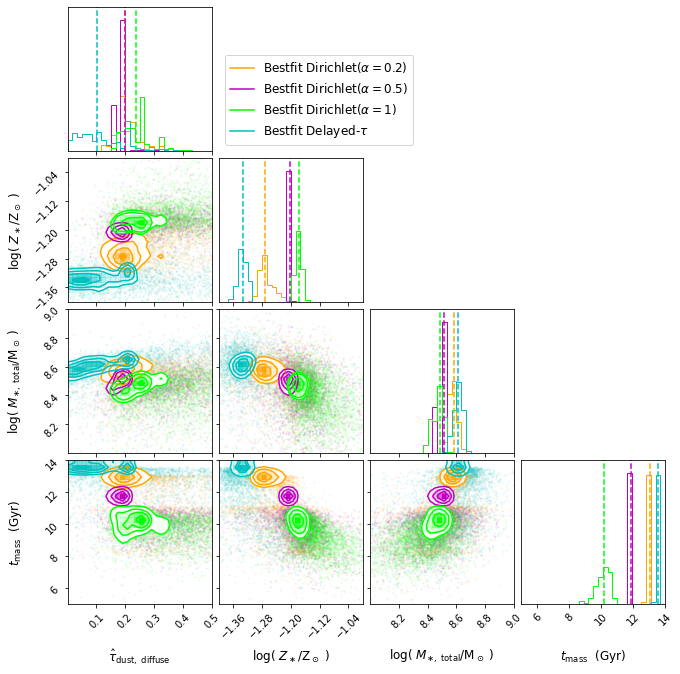

In [10]:
labels = [ parameter_labels_with_units[p] for p in showpars ]
bin_ranges = [ parameter_bounds[p] for p in showpars ]

xparams = dict( labels=labels, smooth=1, range=bin_ranges )
params_base = dict( showpars=showpars, smooth=2, show_titles=1, labels=labels, return_fig=1, xparams=xparams )

fig = None
for key in sfh_keys:
    fig = plotting.plot_corner( result=result_params[key]['result'], color=result_params[key]['posts_params']['color'], 
                                fig=fig, **params_base )
    
if True: # add legend
    ax_legend = fig.get_axes()[1]

    handles, labels = [],[]
    for i,key in enumerate( sfh_keys ):
        pp = result_params[key]
        h, = ax_legend.plot([],[], color=pp['bestfit_params']['color'])
        handles.append( h )
        if 'label' in pp.keys(): l = pp['label']
        elif 'label' in pp['bestfit_params'].keys(): pp['bestfit_params']['label']
        else: l = i+1
        labels.append('Bestfit {}'.format( l ))
     
    ax_legend.legend( handles, labels, loc=3 )    

plt.savefig('figures/compare_fits_DF44-phot_speckKCWI-corner.pdf', bbox_inches='tight', dpi=150)
plt.show()

## plot reconstructed SFH

In [6]:
# sample from prior

# size = int(1e2) # better to have more draws, but takes longer
size = -1 # skip

for key in sfh_keys:
    if size>0:
        prior_draws = prospect_io.get_sfh_priors( result_params[key]['model'], size )
    else:
        prior_draws = None
    result_params[key]['prior_draws'] = prior_draws


In [7]:
# setup styling

hatches = ['//','\\','////','||||','\\\\','/////////']

for i,key in enumerate( result_params.keys() ):
    result_params[key]['obs_params'] = {'marker':'D', 'color':'k', 'ms':12}
    result_params[key]['posts_params'] = {'color':colors[i]}
    result_params[key]['bestfit_params'] = {'lw':1, 'edgecolor':colors[i], 'facecolor':'None', 
                                            'marker':markers[i], 's':160 }
    result_params[key]['priors_params'] = {'facecolor':'None', 'edgecolor':colors[i], 'hatch':hatches[i], 'lw':0 }



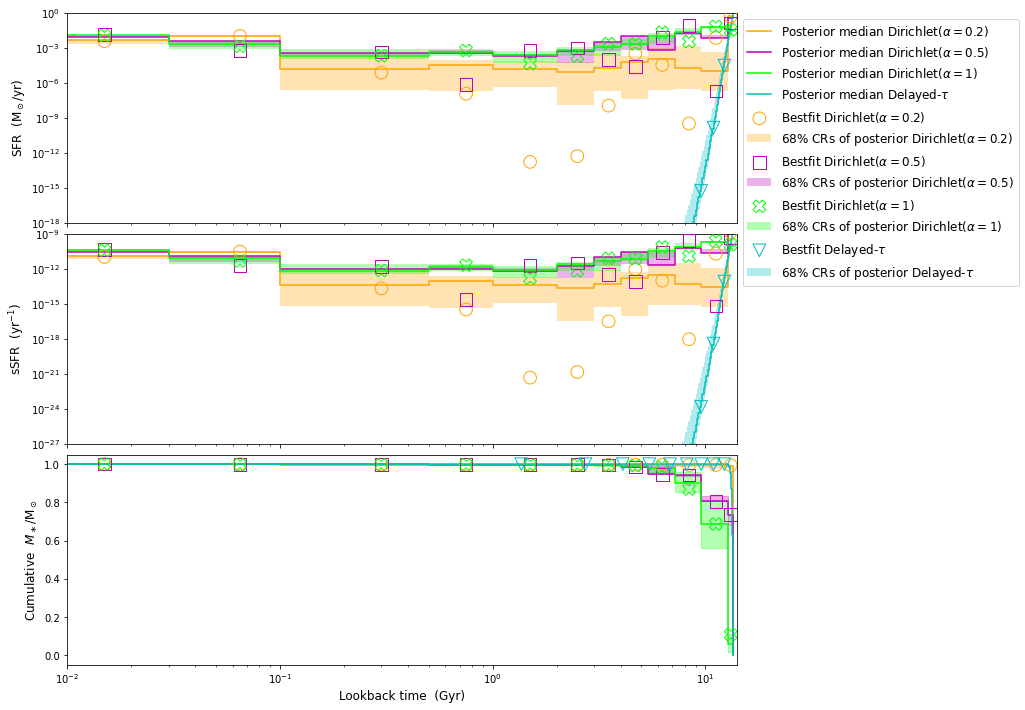

In [8]:
fig, axes = plt.subplots(3,1, figsize=(12,12), sharex=True)
fig.subplots_adjust( wspace=0.05, hspace=0.05 )        
ax_sfr,ax_ssfr,ax_cmf = axes.flatten()

times = np.linspace(0,13.5,100)

for sfh_key in sfh_keys:
    pp = result_params[sfh_key]

    plotting.plot_sfh( ax_sfr, norm_by_mass=False, times=times, **pp )
    plotting.plot_sfh( ax_ssfr, norm_by_mass=True, times=times, **pp )
    plotting.plot_cmf( ax=ax_cmf, xscale='linear', style='step', times=times, **pp )

[ ax.set_xlabel(None) for ax in axes[:-1]]
ax_sfr.legend( loc=2, bbox_to_anchor=[1,1])
ax_sfr.set_xscale('log')
ax_sfr.set_xlim(0.01, 14)

ax_sfr.set_ylim(1e-18,1)
ax_ssfr.set_ylim(1e-27,1e-9)

plt.savefig('figures/compare_fits_DF44-phot_speckKCWI-sfhs.pdf', bbox_inches='tight', dpi=150)
plt.show()